In [65]:
import seaborn as sns
sns.set()

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
from scipy import linalg

# Detecting the resonance off

$\sigma(\omega)=\left( 1+i\omega\tau \right)^{-1}$

In [17]:
class SuperOscillationsResonance:
    
    def __init__(self, omega_measurements, tau1, tau2):
        """
        tau -- resonance width
        """
        # saving parameters
        self.tau1 = tau1
        self.tau2 = tau2
        self.omega_measurements = omega_measurements[np.newaxis, :]
        
        # generating time grids
        self.short_half_period = np.pi / np.abs(self.omega_measurements).max()
        self.short_time = np.linspace(-self.short_half_period, self.short_half_period, 100)[:, np.newaxis]
        
        long_half_period = 2 * np.pi / np.abs(self.omega_measurements).min()
        self.long_time = np.linspace(-long_half_period, long_half_period, 100)[:, np.newaxis]
        
        
        sigma1 = self.sigma(self.omega_measurements, self.tau1)
        self.phase_sigma1 = np.angle(sigma1)
        self.ampl_sigma1 = np.abs(sigma1)
        
        sigma2 = self.sigma(self.omega_measurements, self.tau2)
        self.phase_sigma2 = np.angle(sigma2)
        self.ampl_sigma2 = np.abs(sigma2)
        
        ############################################################################################################
        #
        #  Fit
        #
        ############################################################################################################
        
        self.fit_results = lsq_linear(
            self.freq2time_matrix_sigma1(self.short_time),
            self.peaked_function(self.short_time).reshape(-1)
        )

        # Values of the optimal amplitudes
        self.opt_ampl = self.fit_results['x'].reshape(self.omega_measurements.shape)
        
    def short_time_sigma2(self):
        return np.sum(
            self.opt_ampl * self.freq2time_matrix_sigma2(self.short_time), axis=1
        )
    
    def long_time_sigma2(self):
        return np.sum(
            self.opt_ampl * self.freq2time_matrix_sigma2(self.long_time), axis=1
        )
    
    def short_time_sigma1(self):
        return np.sum(
            self.opt_ampl * self.freq2time_matrix_sigma1(self.short_time), axis=1
        )
    
    def long_time_sigma1(self):
        return np.sum(
            self.opt_ampl * self.freq2time_matrix_sigma1(self.long_time), axis=1
        )
    
    def freq2time_matrix_sigma2(self, t):
        return self.ampl_sigma2 * np.cos(self.omega_measurements * t + self.phase_sigma2 - self.phase_sigma1)
    
    def freq2time_matrix_sigma1(self, t):
        return self.ampl_sigma1 * np.cos(self.omega_measurements * t)
        
    def peaked_function(self, t):
        # Narrow function to approximate to
        return np.exp(-(10 * t / self.short_half_period) ** 2)
                
    @classmethod
    def sigma(cls, omega, tau):
        """
        Drude resonans
        """
        return 1. / (1. + 1j * omega * tau)

In [18]:
res = SuperOscillationsResonance(np.linspace(-80, -40, 5), tau1=0.1, tau2=0.102)


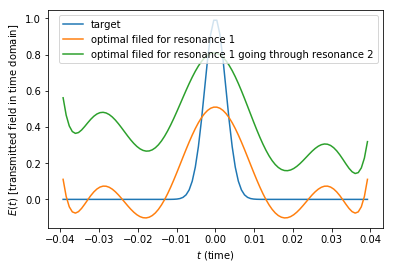

In [19]:
plt.plot(res.short_time, res.peaked_function(res.short_time), label='target')
plt.plot(res.short_time, res.short_time_sigma1(), label='optimal filed for resonance 1')
plt.plot(res.short_time, res.short_time_sigma2(), label='optimal filed for resonance 1 going through resonance 2')
plt.ylabel('$E(t)$ [transmitted field in time domain]')
plt.xlabel('$t$ (time)')
plt.legend()
plt.show()

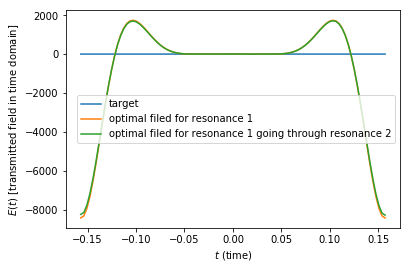

In [20]:
plt.plot(res.long_time, res.peaked_function(res.long_time), label='target')
plt.plot(res.long_time, res.long_time_sigma1(), label='optimal filed for resonance 1')
plt.plot(res.long_time, res.long_time_sigma2(), label='optimal filed for resonance 1 going through resonance 2')
plt.ylabel('$E(t)$ [transmitted field in time domain]')
plt.xlabel('$t$ (time)')
plt.legend()
plt.show()

In [21]:
def format_xticks(x, pos=None):

    if np.isclose(x, 0):
        return "0"

    if x < 0:
        return str(x)

    log10x = np.log10(x)
    exponent = int(np.floor(log10x))
    prefactor = 10. ** (log10x - exponent)

    if np.isclose(prefactor, 1):
        return "$10^{{{:d}}}$".format(exponent)
    else:
        return "${:.0f} \cdot 10^{{{:d}}}$".format(prefactor, exponent)

In [22]:
def plot_superoscilation_fit(omega_measurements, tau1, tau2, max_amplitudes):
    
    omega_measurements = omega_measurements[np.newaxis, :]
    
    # generating time grids
    short_half_period = np.pi / np.abs(omega_measurements).max()
    short_time = np.linspace(-short_half_period, short_half_period, 500)[:, np.newaxis]
        
    long_half_period = 2 * np.pi / np.abs(omega_measurements).min()
    long_time = np.linspace(-long_half_period, long_half_period, 100)[:, np.newaxis]
    
    # peaked function to be fitted to
    peaked_function = 2 * np.exp(-(10 * short_time / short_half_period) ** 2)
    
    # 
    sigma1 = 1. / (1. + 1j * omega_measurements * tau1)
    sigma2 = 1. / (1. + 1j * omega_measurements * tau2)
    
    # fit super oscillations to peaked function for short-time window
    ones = np.ones(omega_measurements.size)
    
    colouring = np.linspace(0., 1., len(max_amplitudes))
    
    plotx, ploty = 2, int(np.ceil(len(max_amplitudes) / 2))
    
    for num, (max_ampl, color_code) in enumerate(zip(max_amplitudes, colouring)):
        
        fit_results = lsq_linear(
            np.abs(sigma1) * np.cos(omega_measurements * short_time),
            peaked_function.reshape(-1),
            bounds=(-max_ampl * ones, max_ampl * ones),
        )
        
        # consistency check
        if not fit_results.success:
            print(fit_results.warning)
        
        if not fit_results.active_mask.any():
            print("At max_ampl = {:.0e} no constraints are activated".format(max_ampl))
    
        field = fit_results.x.reshape(omega_measurements.shape)
        
        if num:
            plt.subplot(plotx, ploty, num + 1, sharex=shared_ax, sharey=shared_ax)
        else:
            shared_ax = plt.subplot(plotx, ploty, num + 1)
            
        plt.title('Max amplitude = {}'.format(format_xticks(max_ampl)))
        
        plt.plot(
            short_time, 
            np.sum(field * np.abs(sigma1) * np.cos(omega_measurements * short_time), axis=1),
            #label='Max amplitude = {}'.format(format_xticks(max_ampl))
        )        
        plt.plot(
            short_time, 
            np.sum(
                field * np.abs(sigma2) * np.cos(omega_measurements * short_time + np.angle(sigma2) - np.angle(sigma1)), 
                axis=1
            ),
            #label='Max amplitude = {}'.format(format_xticks(max_ampl))
        )
        #plt.legend()
        
    plt.show()

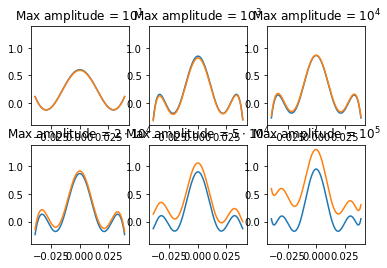

In [23]:
plot_superoscilation_fit(
    omega_measurements=np.linspace(-80, -40, 5), 
    tau1=0.1, 
    tau2=0.102, 
    max_amplitudes=[1e1, 1e3, 1e4, 0.2e5, 0.5e5, 1e5] #np.logspace(1., 5., 4)
)

In [108]:
def discriminability_time_interval(omega_measurements, tau1, tau2, half_durations):
    
    omega_measurements = omega_measurements[np.newaxis, :]
    
    discriminability = []
    
    for half_duration in half_durations:
    
        # generating time grids
        time = np.linspace(-half_duration, half_duration, 1000)[:, np.newaxis]

        # 
        sigma1 = 1. / (1. + 1j * omega_measurements * tau1)
        sigma2 = 1. / (1. + 1j * omega_measurements * tau2)
        
        singular_values = linalg.svdvals(
            (sigma1 - sigma2) * np.exp(1j * time * omega_measurements)
        ).max()
        
        discriminability.append(singular_values)
    
    longest_period = 2. * np.pi / np.abs(omega_measurements).min()
    
    plt.semilogx(2 * half_durations / longest_period, discriminability)
    
    plt.xlabel("The Duration of time-window (in units of $2 \pi / \omega_{\min}$)")
    plt.ylabel("Discriminability (arbitrary units)")

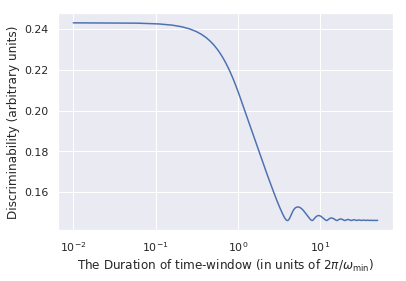

In [109]:
discriminability_time_interval(
        omega_measurements=np.linspace(-80, -40, 5), 
        tau1=0.1, 
        tau2=0.102,
        half_durations=np.linspace(100 * np.pi / 80, 0.01 * np.pi / 40, 1000)
)

plt.show()

In [180]:
def fields_transmitted(omega_measurements, tau1, tau2, half_duration):
    
    omega_measurements = omega_measurements[np.newaxis, :]
    
    time = np.linspace(-half_duration, half_duration, 1000)[:, np.newaxis]

    # 
    sigma1 = 1. / (1. + 1j * omega_measurements * tau1)
    R1 = sigma1 * np.exp(1j * time * omega_measurements)
    
    sigma2 = 1. / (1. + 1j * omega_measurements * tau2)
    R2 = sigma2 * np.exp(1j * time * omega_measurements)
    
    U, s, Vh = linalg.svd(R1 - R2, full_matrices=False)
    
    E1_out = R1.dot(Vh[0]).real
    E2_out = R2.dot(Vh[0]).real
        
    print("Signular value {}".format(s[0]))
    
    print(np.abs(sigma1 / sigma2).max() - 1)
    
    longest_period = 2. * np.pi / np.abs(omega_measurements).min()
        
    plt.plot(time / longest_period, E1_out)
    plt.plot(time / longest_period, E2_out)
    
    print(np.abs(E1_out / E2_out).max() - 1)
    
    plt.xlabel("time, $t$ (in units of $2 \pi / \omega_{\min}$)")
    plt.ylabel('$E(t)$')

Signular value 0.24302523405675194
0.01969527876638799
0.03166341448222476


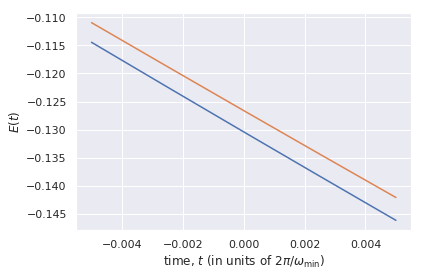

In [186]:
fields_transmitted(
        omega_measurements=np.linspace(-80, -40, 5), 
        tau1=0.1, 
        tau2=0.102,
        half_duration=(0.01 * np.pi / 40)
    )